# Import Packages

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import lxml
import time
from collections import OrderedDict
import re

# Proxy Rotation...
근데 잘 작동하지도 않을 뿐더러, 이런 소규모 프로젝트(?)에 굳이 이정도의 function까지 넣을 필요가 있을까 싶다.

In [2]:
from lxml.html import fromstring
import requests
from itertools import cycle
import traceback

def get_proxies():
    ua=UserAgent()
    headers = {'User-Agent':ua.random}
    url='https://free-proxy-list.net/'

    r=requests.get(url,headers=headers)
    page = BeautifulSoup(r.text, 'html.parser')

    proxies=[]

    for proxy in page.find_all('tr'):
        i=ip=port=0

    for data in proxy.find_all('td'):
        if i==0:
            ip=data.get_text()
        if i==1:
            port=data.get_text()
        i+=1

    if ip!=0 and port!=0:
        proxies+=[{'http':'http://'+ip+':'+port}]

    return proxies

# 코드 순서

1. 리그 오브 레전드 사이트에서 '챔피언 리스트'를 가져온다.
    * function: scrape_champs()
    
    
2. '단일 챔피언'의 나무위키에 들어가 대사를 가져온다
    * 나무 위키 경우의 수  
       <1> https://namu.wiki/w/{name}/대사
       <2> https://namu.wiki/w/{name}(리그 오브 레전드)/대사  
       <3> https://namu.wiki/w/{name}(리그 오브 레전드)#s-3  
       <4> https://namu.wiki/w/{name}#s-3  
    * 예를 들어 '케일' 같은 경우, 애초에 '식물' 또는 '천사'로서의 나무위키를 갖고 있어,  
    (리그 오브 레전드)가 뒤에 붙어 특정화 시켜야 한다.
    * function: namu_by_name(name)  
    
    
3. 대사들이 ""(Double Quote)안에 존재하므로 "" 안의 대사들을 모아줘야 한다.
    * find_double_quotes_and_erase
    

4. 대사 이외에 불필요한 괄호 요소들이 도처에 존재한다. 제거하자.
    * erase_brackets_and_sons(content)
    
    
5. 지나치게 빠르게 적용하면 프로그램이라는 것이 걸려버리니 3초 정도 여유를 주자.
    * time.sleep(3)
    
    

# Function List

In [2]:
def scrape_champs():
    req = requests.get('https://kr.leagueoflegends.com/ko-kr/champions/')
    html = req.text
    soup = bs(html, 'html.parser')
    champs = soup.select('span.gPUACV')
    
    return champs


def namu_by_name(name):
    req_candidate = [f'https://namu.wiki/w/{name}/대사',
                     f'https://namu.wiki/w/{name}(리그 오브 레전드)/대사',
                     f'https://namu.wiki/w/{name}(리그 오브 레전드)#s-3',
                     f'https://namu.wiki/w/{name}#s-3'
                    ]
    num = 0
    while num < len(req_candidate):
        req = requests.get(req_candidate[num])
        if req.status_code != 200:
            num += 1
        else:
            return req
        

def to_text(target):
    to_text = lambda x: x.text
    target = list(map(to_text, target))
    return target

def find_double_quotes_and_erase(line):
    Find_double_quotes = re.compile('"([^"]*)"', re.DOTALL|re.MULTILINE|re.IGNORECASE) # Ignore case not needed here, but can be useful.
    clean_line = Find_double_quotes.findall(line)
    return clean_line

def erase_brackets_and_sons(content):
    function = lambda x: re.sub("[\[\(].*?[\)\]]", '', x)
    
    content = list(map(function, content))
    return content

def champs_quote(champ_list):

    quote_dic = OrderedDict()
    for champ_name in champ_list:
        quote_dic[champ_name] = champ_quote(champ_name)

    return quote_dic

# def eradicate_blank_from_list(target):
#     target = ' '.join(target).split()
#     return target

def champ_quote(champ_name):
    need_to_erase = ['[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]', '[8]', '[9]', '[10]', '', ' ', '  ']
    quote_dic = {}
    
    
    if namu_by_name(champ_name).status_code == 200:

        namu_champ = namu_by_name(champ_name).text
        namu_champ_soup = bs(namu_champ, 'html.parser')
        namu_champ_lines = namu_champ_soup.select('blockquote.wiki-quote')
        
        for line in namu_champ_lines:
            lines = str(line)
            lines = lines.replace('<br/>', '"')
            lines = bs(lines, 'html.parser')
            lines = lines.text.split('"')            
            category, contents = lines[0], lines[1:]
            category = re.sub("[\[\(].*?[\)\]]", '', category)
            if contents == []:
                continue
                
            if category != '' and len(category) < 20:
                contents = erase_brackets_and_sons(contents)
                contents = [content for content in contents if content not in need_to_erase]
                quote_dic[category] = contents
                
#             if len(lines) != 0:
#                 if line.select('strong') == []:
#                     category = '미분류'
#                 else:
#                     category = str(line.select('strong')[0].text)
# #                 print(category)
# #                 print(quote_dic)
# #                 quote_dic[champ_name][category] = []

#                 quotes = line.text

#                 clean_quotes = find_double_quotes_and_erase(quotes)
#                 clean_quotes = erase_brackets_and_sons(clean_quotes)
#                 if clean_quotes != []:
#                     quote_dic[category] = clean_quotes

        print(f'Done {champ_name}')
        print('Sleeping 3 secs')
        time.sleep(3)

    else:
        print(f'Error in {champ_name}')
        
    return quote_dic
    

In [198]:
champ_quote('아무무')

Done 아무무
Sleeping 3 secs


{'선택 시': ['날 선택해줄 줄은 정말 몰랐어..'],
 '이동/공격': ['아우…….',
  '알았어.',
  '나랑 놀자…….',
  '어… 가지 마!',
  '새 친구를 찾아보자.',
  '우리, 어디 가는 거야?'],
 '도발': ['이리 와……. 안아줄게!'],
 '농담': ['우리… 영원히 친구하자!']}

# Function Test

In [195]:
# 모든 챔피언 이름 가져오기(리그오브레전드 본 사이트)

all_champs = to_text(scrape_champs())
print(all_champs)
print(f'length of champs are {len(all_champs)}')
# 실제 148 챔피언들의 숫자와 같다

['가렌', '갈리오', '갱플랭크', '그라가스', '그레이브즈', '나르', '나미', '나서스', '노틸러스', '녹턴', '누누와 윌럼프', '니달리', '니코', '다리우스', '다이애나', '드레이븐', '라이즈', '라칸', '람머스', '럭스', '럼블', '레넥톤', '레오나', '렉사이', '렝가', '루시안', '룰루', '르블랑', '리 신', '리븐', '리산드라', '마스터 이', '마오카이', '말자하', '말파이트', '모데카이저', '모르가나', '문도 박사', '미스 포츈', '바드', '바루스', '바이', '베이가', '베인', '벨코즈', '볼리베어', '브라움', '브랜드', '블라디미르', '블리츠크랭크', '빅토르', '뽀삐', '사이온', '사일러스', '샤코', '세나', '세주아니', '세트', '소나', '소라카', '쉔', '쉬바나', '스웨인', '스카너', '시비르', '신 짜오', '신드라', '신지드', '쓰레쉬', '아리', '아무무', '아우렐리온 솔', '아이번', '아지르', '아칼리', '아트록스', '아펠리오스', '알리스타', '애니', '애니비아', '애쉬', '야스오', '에코', '엘리스', '오공', '오른', '오리아나', '올라프', '요릭', '우디르', '우르곳', '워윅', '유미', '이렐리아', '이블린', '이즈리얼', '일라오이', '자르반 4세', '자야', '자이라', '자크', '잔나', '잭스', '제드', '제라스', '제이스', '조이', '직스', '진', '질리언', '징크스', '초가스', '카르마', '카밀', '카사딘', '카서스', '카시오페아', '카이사', '카직스', '카타리나', '칼리스타', '케넨', '케이틀린', '케인', '케일', '코그모', '코르키', '퀸', '클레드', '키아나', '킨드레드', '타릭', '탈론', '탈리야', '탐 켄치', '트런들', '트리스타나', '트린다미어', '트위스티드 페이트', '트위치', 

In [199]:
result = champs_quote(all_champs)

Done 가렌
Sleeping 3 secs
Done 갈리오
Sleeping 3 secs
Done 갱플랭크
Sleeping 3 secs
Done 그라가스
Sleeping 3 secs
Done 그레이브즈
Sleeping 3 secs
Done 나르
Sleeping 3 secs
Done 나미
Sleeping 3 secs
Done 나서스
Sleeping 3 secs
Done 노틸러스
Sleeping 3 secs
Done 녹턴
Sleeping 3 secs
Done 누누와 윌럼프
Sleeping 3 secs
Done 니달리
Sleeping 3 secs
Done 니코
Sleeping 3 secs
Done 다리우스
Sleeping 3 secs
Done 다이애나
Sleeping 3 secs
Done 드레이븐
Sleeping 3 secs
Done 라이즈
Sleeping 3 secs
Done 라칸
Sleeping 3 secs
Done 람머스
Sleeping 3 secs
Done 럭스
Sleeping 3 secs
Done 럼블
Sleeping 3 secs
Done 레넥톤
Sleeping 3 secs
Done 레오나
Sleeping 3 secs
Done 렉사이
Sleeping 3 secs
Done 렝가
Sleeping 3 secs
Done 루시안
Sleeping 3 secs
Done 룰루
Sleeping 3 secs
Done 르블랑
Sleeping 3 secs
Done 리 신
Sleeping 3 secs
Done 리븐
Sleeping 3 secs
Done 리산드라
Sleeping 3 secs
Done 마스터 이
Sleeping 3 secs
Done 마오카이
Sleeping 3 secs
Done 말자하
Sleeping 3 secs
Done 말파이트
Sleeping 3 secs
Done 모데카이저
Sleeping 3 secs
Done 모르가나
Sleeping 3 secs
Done 문도 박사
Sleeping 3 secs
Done 미스 포츈
Sleeping 3 secs
Done 바드
Slee

In [148]:
# 나의 사랑스러운 쉔으로 한번 테스트 해보자

shen_quote = namu_by_name('쉔')
print(shen_quote)
# Response 200으로 정상적 결과를 내는 것을 볼 수 있다.

<Response [200]>


In [144]:
# 현재 soup 상태라서 매우 더러운 상태이다. Text 버전으로 바꾸어주자.

shen_quote_text = shen_quote.text
shen_quote_soup = bs(shen_quote_text, 'html.parser')
shen_quote_lines = shen_quote_soup.select('span#대사 > blockquote.wiki-quote > div.wiki-paragraph')
shen_quote_lines

[]

In [94]:
champion_says = champs_quote(all_champs)
champion_says

Done 가렌
Sleeping 3 secs
Done 갈리오
Sleeping 3 secs
Done 갱플랭크
Sleeping 3 secs
Done 그라가스
Sleeping 3 secs
Done 그레이브즈
Sleeping 3 secs
Done 나르
Sleeping 3 secs


KeyboardInterrupt: 

# 일부 수정이 필요한 부분이 있을 수 있으니 PICKLE로 저장

In [4]:
import pickle



In [200]:
with open("champion_says.pickle", "wb") as fw:
    pickle.dump(result, fw)

In [5]:
with open("champion_says.pickle","rb") as fr:
    result = pickle.load(fr)

In [6]:
len(result)

148

In [7]:
result['클레드']

{'게임 시작': ['인간들인가?',
  ' / ',
  '그냥 먹거리구만.',
  '뭐? 어- 그러니까. 싹 다 해치우면 된다 이거야. 그래, 그러지 뭐!',
  '여긴 내 땅이다! 전부 다아아아아아아 내 땅이라고!',
  '이런 젠X!! 여기가 어디야!',
  ' / ',
  '싹 쓸어서 길을 터야겠군!',
  '내가 처음 지휘 대장 사령관에 임명된게 아마 폴그램 전투였지? 뭐, 대충 그런 계급이었던것 같던데. 에이 잡기전에 물어볼껄.',
  '우리가 트레베일을 점령했는데, 그 장군이라는 놈이 전리품을 나누자고 했던거 기억나? 별... 장군이고 뭐고 죽을땐 똑같더만.',
  '이 클레드님으로 말할 것 같으면, 1사단 최고 사령관의 3중대 지휘 대대장 8군 부참모총장님이시다! 납작 엎드리시지!'],
 '공격': ['누구 좀 패주게 천천히 좀 가란 말이야!',
  '내 잔디 밟지 말랬지이!',
  '다~ 죽었어~!',
  '이 땅! 내 땅!',
  '이런 망할 무단침입자들!',
  '한번만 더 내 땅을 넘보면 그땐 끝이다!',
  '도끼맛이 그렇게 궁금해?',
  '내 휴식을 방해하는 녀석, 누구야?!',
  '도망치라니까? 스칼은 산채로 잡아먹어!',
  '방해 좀 그만해! 나 전투 좀 하자!',
  '도시 촌놈들 딱 질색이야.',
  '난 클레드, 이쪽은 스칼. 자, 이제 죽어보실까?',
  '어떻게 될지 궁금해? 내가 널 처치하고, 네 걸 다 빼앗을꺼야!',
  '우리 스칼, 저녁 시간이다!',
  '오는 길에 환영 표지판 못봤나? 그래! 네 친구 머리통에 쓴거!',
  '클레드님을 만났으면 경례부터 해야지!',
  '무단침입자들에게 종말을!',
  '왜 날 보고 경례를 안해? 경례가 먼저잖아! 당장 경례하라고오오!',
  '내 초대장은 받았나? 아냐? 내가 보내준게 없거드은!!',
  '좋아! 해보자!',
  '그래! 덤벼!',
  '환영 선물을 주지!',
  '까불이 가라사대, 네놈은 끝났다아!',
  '스칼 뱃속에서 자~알 살아봐라.',
  '물어,

In [211]:
list(result['우르곳'].values())

[['드레지도 모르는 애송이들, 혼쭐을 내 주마!',
  '마지막을 만끽해라. 심판이 머지 않았으니.',
  '때가 왔다. 죽음을 선사할 때가...!',
  '녀석들을 조종하긴 쉽지. 목을 움켜쥐기만 하면 되거든!',
  '쓰레기의 존재가 감지되었다.',
  '살상기계 준비 완료!'],
 ['목표 설정 완료.',
  '쉴 수 없다.',
  '이 고통을 끝내줘.',
  '공포가 무엇인지 알려주지.',
  '영원한 고통의 선물.',
  '시스템 준비 완료.',
  '운이 좋다면 목숨만 잃게 될 것이다.',
  '존재함이 곧 고통이지.',
  '유압 장치 가동.'],
 ['처형 실시.',
  '쓰레기의 존재가 탐지되었다.',
  '나만이 살아남을 것이다.',
  '그들은 저주받았다.',
  '반드시... 처벌한다.',
  '죽음만이 유일한 탈출구다.'],
 ['넌 절대 날 이길 수 없다. 그러니 차라리 내 몸의 일부가 되도록 해! 쓸만한 다리가 필요하다.'],
 ['대의를 위한 희생이다.',
  '쇠사슬을 감아올려라. 자운에게 한 수 가르쳐 줄 때다.',
  '약점을 인정해라.',
  '하나가 쓰러지고, 여럿이 일어나리라.',
  '실망이군.',
  '자, 이제 네가 아끼는 걸 모두 부숴주지!',
  '이제야 네 주제를 알게 됐군.',
  '내가 더 강했을 뿐.',
  '자운에게 내리는 경고다.',
  '학살 중',
  '고작 이거냐?',
  '내 시간을 낭비하지 마라!',
  '보기 딱할 지경이군!',
  '적 학살 중',
  '네 무자비함은... 인정하마.'],
 ['힘을 모아둬라. 곧 내 것으로 만들 것이니.', '네 죽음은 내 손에 달렸다.'],
 ['자운이 처형인을 부른다...!', '지하로부터... 공명하는 힘을 느껴라.', '우리의 비상을 막을 순 없다.'],
 ['너의 종말로부터 구원받을 방법은 없다.', '두렵나? 곧... 공포도 느끼지 못하게 될 것이다.'],
 ['종말이 머지 않았다!',
  '약점을 모조리 도려내주지!',
  '쇠사슬로 자유를 

In [217]:
def turn_into_one_list(groups):
    total = []
    for group in groups:
        total += group
    return total

def combine_all_line_values(dictionary):
    return_dict = {}
    for key in dictionary.keys():
        values = list(dictionary[key].values())
        values = turn_into_one_list(values)
        return_dict[key] = values
    return return_dict

In [218]:
total_result = combine_all_line_values(result)

In [219]:
total_result

{'가렌': ['승리가 눈 앞에 있다!',
  '저주 받을 악당 놈들.',
  '악행과 싸워라!',
  '내가 선두에 서겠다!',
  '비열한 놈들.',
  '악의 무리는 죗값을 치르리라!',
  '전진!',
  '데마시아를 위하여!',
  '국왕 전하의 이름으로.',
  '내 친히 적들을 심판하겠다.',
  '지체 없이.',
  '명령만 내리십시오.',
  '두려워 마라. 내가 간다!',
  '우리의 영토를 지키기 위하여!',
  '언제든 준비되어 있다.',
  '악당은 침묵하라! ',
  '일격필살!',
  '내 정의를 받아라!',
  '데마시아를 위하여!',
  '쫓아내주마! ',
  '부숴버려라!! ',
  '참회하라!!',
  '신성한 정의를 위하여! ',
  '너는 버림받았다!',
  '돌격!',
  '데마시아!',
  '심판을 받아라!',
  '너는 버림받았다! ',
  '심판을 받아라!',
  '가치가 없군!',
  '내 이름을 기억해라!',
  '감히!',
  '신을 믿지 않는 자여!',
  '추악한 괴물!',
  '데마시아가 군림하리라!',
  '대의를 위해!',
  '정의를 위해!',
  '앞으로 나와 명예롭게 죽음을 맞이하라!',
  '녹서스의 마수를 뻗치시겠다? 그 손목을 잘라주지!',
  '다리우스, 네 놈은 장군이 아니라 도살자에 불과하다!',
  '빨리 좀 끝내지? 화장실 급하단 말이야~',
  '날 소환하면 후회하지 않게 해주지. 수풀만 준비해줘. OK?',
  '다리우스, 너 따위는 한 주먹도 안 돼!',
  '데마시아!',
  '백만스물 하나! 백만스물 둘! 오, 거기 있는 줄 몰랐소.',
  '데마시아~흫아흫아',
  '내 왕좌는.... 남아.... 있....으윽.',
  '나는... 신이다...',
  '데마시아! 네 목소리가 들린다! ',
  '치유되었다. ',
  '대의가 내게 힘을 주는군! ',
  '헌신이 날 회복시킨다!',
  '저들은 신을 죽일 수 있다고 믿었던건가!',
  '네 소원이 이루어졌다.',
  '입을

In [293]:
total_result['소나']

["'당신만이 절 들을 수 있어요, 소환사님. 오늘은 어떤 명작을 연주해볼까요?'",
 "'아주 빠르게요.' ",
 "'음악을 통한 질서를.'",
 "'활기차게! 활기차게!'",
 "'이 불협화음을 해결해볼까요?'",
 "'팡파르가 울려 퍼져요.'",
 "'정의의 교향곡을.'",
 "'우린 마음으로 이야기하죠.' ",
 "'느리게요, 소환사님.'",
 "'조화롭게.'",
 "'우아하게'",
 "'완벽한 박자로.' ",
 "'환상적인 듀엣이네요.'",
 "'4분의 1박자로.'",
 "'메트로놈처럼 정확하게.' ",
 "'좀더 신속하게, 알겠어요.'"]

In [283]:
{key: len(value) for key, value in total_result.items()}

{'가렌': 67,
 '갈리오': 147,
 '갱플랭크': 53,
 '그라가스': 18,
 '그레이브즈': 28,
 '나르': 40,
 '나미': 37,
 '나서스': 51,
 '노틸러스': 20,
 '녹턴': 43,
 '누누와 윌럼프': 185,
 '니달리': 14,
 '니코': 155,
 '다리우스': 250,
 '다이애나': 27,
 '드레이븐': 57,
 '라이즈': 200,
 '라칸': 311,
 '람머스': 17,
 '럭스': 175,
 '럼블': 57,
 '레넥톤': 33,
 '레오나': 30,
 '렉사이': 0,
 '렝가': 30,
 '루시안': 365,
 '룰루': 31,
 '르블랑': 34,
 '리 신': 21,
 '리븐': 262,
 '리산드라': 44,
 '마스터 이': 66,
 '마오카이': 72,
 '말자하': 19,
 '말파이트': 17,
 '모데카이저': 83,
 '모르가나': 152,
 '문도 박사': 34,
 '미스 포츈': 17,
 '바드': 0,
 '바루스': 22,
 '바이': 41,
 '베이가': 74,
 '베인': 225,
 '벨코즈': 59,
 '볼리베어': 117,
 '브라움': 92,
 '브랜드': 27,
 '블라디미르': 22,
 '블리츠크랭크': 14,
 '빅토르': 25,
 '뽀삐': 87,
 '사이온': 133,
 '사일러스': 191,
 '샤코': 14,
 '세나': 196,
 '세주아니': 32,
 '세트': 146,
 '소나': 16,
 '소라카': 28,
 '쉔': 18,
 '쉬바나': 11,
 '스웨인': 146,
 '스카너': 80,
 '시비르': 67,
 '신 짜오': 18,
 '신드라': 27,
 '신지드': 9,
 '쓰레쉬': 151,
 '아리': 284,
 '아무무': 9,
 '아우렐리온 솔': 249,
 '아이번': 248,
 '아지르': 108,
 '아칼리': 103,
 '아트록스': 194,
 '아펠리오스': 129,
 '알리스타': 8,
 '애니': 29,
 '애니비아': 32,
 

In [288]:
length_dict = {key: len(value) for key, value in total_result.items()}
length_dict = OrderedDict(sorted(length_dict.items(), key=lambda x:x[1]
                                ))
length_dict

OrderedDict([('렉사이', 0),
             ('바드', 0),
             ('알리스타', 8),
             ('신지드', 9),
             ('아무무', 9),
             ('카사딘', 10),
             ('쉬바나', 11),
             ('질리언', 12),
             ('니달리', 14),
             ('블리츠크랭크', 14),
             ('샤코', 14),
             ('케넨', 14),
             ('코그모', 15),
             ('소나', 16),
             ('람머스', 17),
             ('말파이트', 17),
             ('미스 포츈', 17),
             ('잭스', 17),
             ('그라가스', 18),
             ('쉔', 18),
             ('신 짜오', 18),
             ('코르키', 18),
             ('말자하', 19),
             ('오공', 19),
             ('탈론', 19),
             ('노틸러스', 20),
             ('엘리스', 20),
             ('리 신', 21),
             ('바루스', 22),
             ('블라디미르', 22),
             ('자르반 4세', 23),
             ('케이틀린', 23),
             ('피즈', 23),
             ('오리아나', 24),
             ('빅토르', 25),
             ('제드', 25),
             ('카타리나', 25),
             ('헤카림', 26),
          

In [289]:
sns.set()
sns.set_context('poster')
plt.rcParams['font.family'] = 'AppleGothic'

In [290]:
dict_key = list(length_dict.keys())
dict_value = list(length_dict.values())

In [291]:
result['피들스틱']

{'게임 시작': ['그게 쫓아오고 있어. 우리가 겁 먹은 걸 아는 거야…'],
 '이동': ['다들, 행복하신가!',
  '뚜루루뚜 따라라라따 따라!',
  '풍선 줄까~?',
  '웃다가, 울다가, 사라져라!',
  '왜 아무도! 내 안부는, 궁금해 하지 않는 거야!',
  '광대 공포증이란 단어가... 생각 안 나셨나?',
  '웃음이 최고의 보약이지.',
  '광대가 도망쳤다고? 어디!',
  '커다란 신발 속, 비쩍 마른 다리를, 하나씩, 하나씩!',
  '내 장갑이 마음에 들어? 손 좀 이리 줘봐!',
  '종말이, 흐흐흐, 머지 않았어.',
  '오늘 우린 파티를 즐길 거야, 절대, 끝나지 않을 파티!',
  '난, 피들스틱! 설명이 더 필요해?',
  '내 유머를 감상할 시간이야!',
  '재밌어, 그리고, 무서워!',
  '광대는 항상 행복하지.',
  '피들스틱과 함께라면, 모든 파티가, 죽여주지!',
  '깜짝 파티는 방금 시작했어!',
  '날 싫어하는 사람은 없을걸~?',
  '모두 죽게 될 걸? 파티를 열어 알아보자고!',
  '인생은 파티야. 목숨 걸 정도지.',
  '축하 파티 좀 한다고 죽는 사람은 없어!',
  '네 인생 최고의 파티가 될 거야!',
  '지금까지 해치운 녀석들이, 진정한, 깜짝 선물 아니었을까?',
  '그래, 그거야...',
  '나 잡아봐라!'],
 '장거리 이동': ['내 삶의 원동력은 웃음이지! 그리고, 비명도!',
  '병에 걸린 거 같아. 바로, 웃음병 말이야!',
  '오늘 파티 주인공이 누구라고? 전부 다? 너무 신나잖아!',
  '난 뇌가 없어... 너도 곧 그렇게 될 거야!',
  '놀이공원의 진짜 재미는, 어둠 속에서 비명을 지를 때지!',
  '광대는 예술이야. 아주 진지한... 예술이지.',
  '웃음은, 영원하지. 아주 진실되고, 강력한 친구야!',
  '악마일까? 광대일까? 직접 알아볼래?으하!',
  '난 인생이 희극인 줄 알았어. 근데 알고 보니... 공포였던 거야!',
  '광대

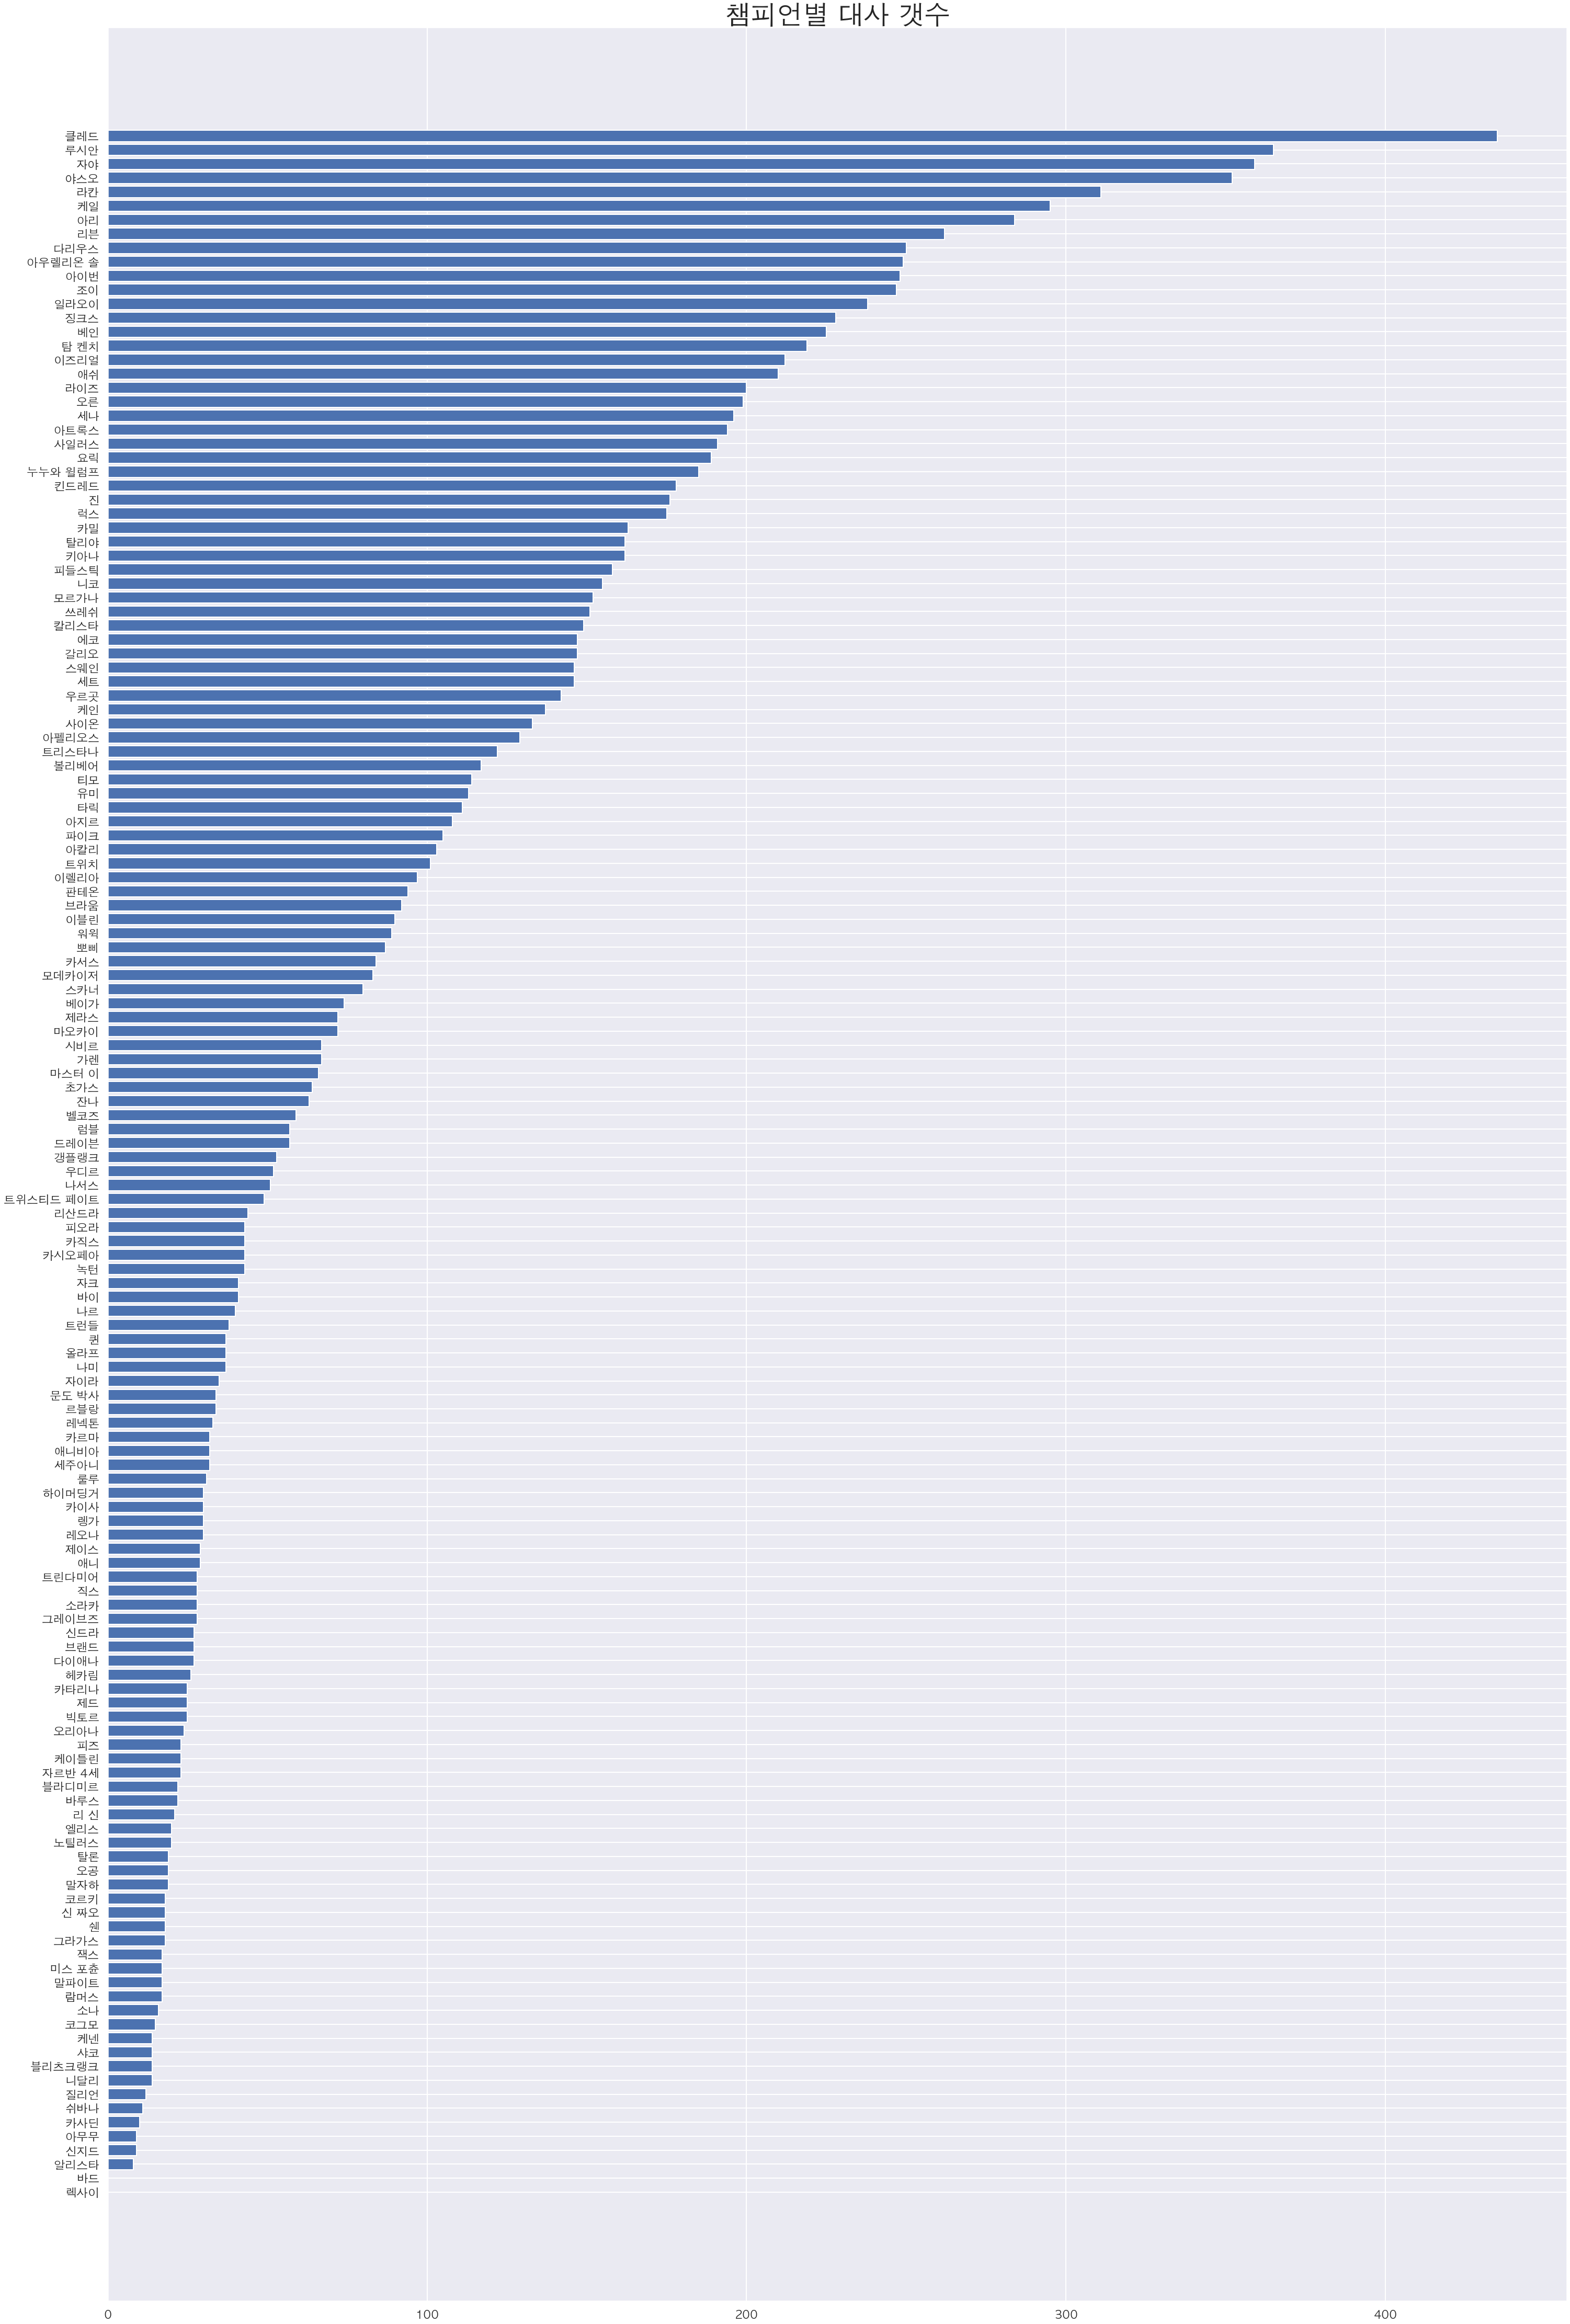

In [292]:
fig, ax = plt.subplots(figsize = (50,80))
plt.title('챔피언별 대사 갯수', fontsize=50)
plt.barh(dict_key, dict_value)

plt.savefig('champion_quotes_count.png')
plt.show()